In [ ]:
!pip install spams-bin
!pip install staintools

In [32]:
import os
import glob
import pickle
import random 
# import staintools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.cluster.vq import vq
from skimage.util.shape import view_as_windows
from keras.preprocessing.image import img_to_array, load_img, array_to_img

ROOT_DIR = '/content/drive/MyDrive/NucleiSegmentation'
os.chdir(ROOT_DIR)

DATASET = "MOSID"
PATCH_WIDTH, PATCH_HEIGHT = 256, 256
IMAGE_SIZE = (1000, 1000)
NORMALIZE = False

# image size - (1000, 1000) for MOSID
# image size - (512, 512) for TNBC

In [ ]:
plt.imshow()

In [ ]:
# MOSID - TCGA-B0-5711-01Z-00-DX1.png
# TNBC - 04_3.png

def get_stain_template():
  
  normalizer = staintools.StainNormalizer(method='vahadane')
  filepaths = glob.glob(os.path.join(ROOT_DIR, "data", "raw", DATASET, "Training", "TissueImages", "*"))

  stain_matrices = []
  for f in filepaths:
    img = staintools.read_image(f)
    img = staintools.LuminosityStandardizer.standardize(img)
    normalizer.fit(img)
    stain_matrices.append(normalizer.stain_matrix_target.flatten())
  
  kmeans = KMeans(n_clusters=1)
  kmeans.fit(stain_matrices)
  closest, distances = vq(kmeans.cluster_centers_, stain_matrices)

  print("Stain template : ", filepaths[closest[0]])
  plt.imshow(array_to_img(load_img(filepaths[closest[0]])))
  return filepaths[closest[0]]

In [ ]:
normalizer = staintools.StainNormalizer(method='vahadane')

if NORMALIZE:
  stain_template = get_stain_template()
  target_image = staintools.read_image(stain_template)
  target_image = staintools.LuminosityStandardizer.standardize(target_image)
  normalizer.fit(target_image)

In [ ]:
result = {'Training' : {'TissueImages' : [], 'GroundTruth' : []},'Testing' : {'TissueImages' : [], 'GroundTruth' : []},'Validation' : {'TissueImages' : [], 'GroundTruth' : []}}

filepaths = {'Training' : {'TissueImages' : [], 'GroundTruth' : []},'Testing' : {'TissueImages' : [], 'GroundTruth' : []},'Validation' : {'TissueImages' : [], 'GroundTruth' : []}}

def get_GroundTruth_files(dataset, subset):
  
  tissue_image_files = filepaths[subset]['TissueImages']
  files= []
  for f in tissue_image_files:
    if dataset == "MOSID": 
      files.append(f.replace("TissueImages","GroundTruth").replace(".png","_bin_mask.png").replace(".tif","_bin_mask.png"))
    elif dataset == "TNBC":
      files.append(f.replace("TissueImages","GroundTruth"))
  return files 


def get_GroundTruth_patches(dataset, subset):
  
  files = get_GroundTruth_files(dataset, subset)
  patches = []
  filepaths[subset]['GroundTruth'] = files
  for file in files:
    img = img_to_array(load_img(file, color_mode = 'grayscale', target_size= IMAGE_SIZE))
    img = img/255.0
    new_imgs = view_as_windows(img, (PATCH_WIDTH, PATCH_HEIGHT,1), (PATCH_WIDTH//2, PATCH_HEIGHT//2, 1))
    for patch in new_imgs: patches.append(patch)
  patches = np.array(patches)
  patches = patches.reshape(-1, PATCH_HEIGHT, PATCH_WIDTH, 1) 
  return patches


def get_TissueImages_patches(dataset, subset):
  
  files = glob.glob(os.path.join(ROOT_DIR, "data", "raw", dataset, subset, "TissueImages", "*"))
  filepaths[subset]['TissueImages'] = files 
  patches = []
  for file in files:
    new_images = []
    if NORMALIZE:
      image = staintools.read_image(file)
      image = staintools.LuminosityStandardizer.standardize(image)
      normalized_image = normalizer.transform(image)
      new_images = view_as_windows(normalized_image, (PATCH_WIDTH, PATCH_HEIGHT,3), (PATCH_WIDTH//2, PATCH_HEIGHT//2, 3))
    else:
      image = img_to_array(load_img(file, color_mode = 'rgb', target_size= IMAGE_SIZE))
      new_images = view_as_windows(image, (PATCH_WIDTH, PATCH_HEIGHT,3), (PATCH_WIDTH//2, PATCH_HEIGHT//2, 3))
    for patch in new_images: patches.append(patch)
  patches = np.array(patches)
  patches = patches.reshape(-1, PATCH_HEIGHT, PATCH_WIDTH, 3)
  return patches  

In [ ]:
for subset in ['Training','Testing','Validation']:
  result[subset]['TissueImages'] = get_TissueImages_patches(DATASET, subset)
  result[subset]['GroundTruth'] =  get_GroundTruth_patches(DATASET, subset)

if NORMALIZE:
  with open(os.path.join(ROOT_DIR,"data","processed","normalized", DATASET + ".dat"),"wb") as f : pickle.dump(result,f)
else:
  with open(os.path.join(ROOT_DIR,"data","processed","unnormalized", DATASET + ".dat"),"wb") as f : pickle.dump(result,f)

## Testing

In [3]:
DISPLAY_DATASET = "MOSID"
with open(os.path.join(ROOT_DIR,"data","processed","normalized", DISPLAY_DATASET + ".dat"),"rb") as f : normalized_dataset = pickle.load(f)
with open(os.path.join(ROOT_DIR,"data","processed","unnormalized", DISPLAY_DATASET + ".dat"),"rb") as f : unnormalized_dataset = pickle.load(f)

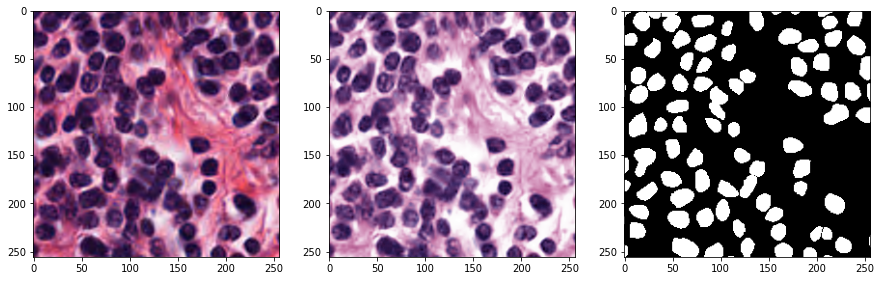

In [31]:
fig, axs = plt.subplots(1, 3, figsize = (15,15))
axs[0].imshow(array_to_img(unnormalized_dataset['Training']['TissueImages'][574]))
axs[1].imshow(array_to_img(normalized_dataset['Training']['TissueImages'][574]))
axs[2].imshow(array_to_img(normalized_dataset['Training']['GroundTruth'][574]), cmap = "gray")

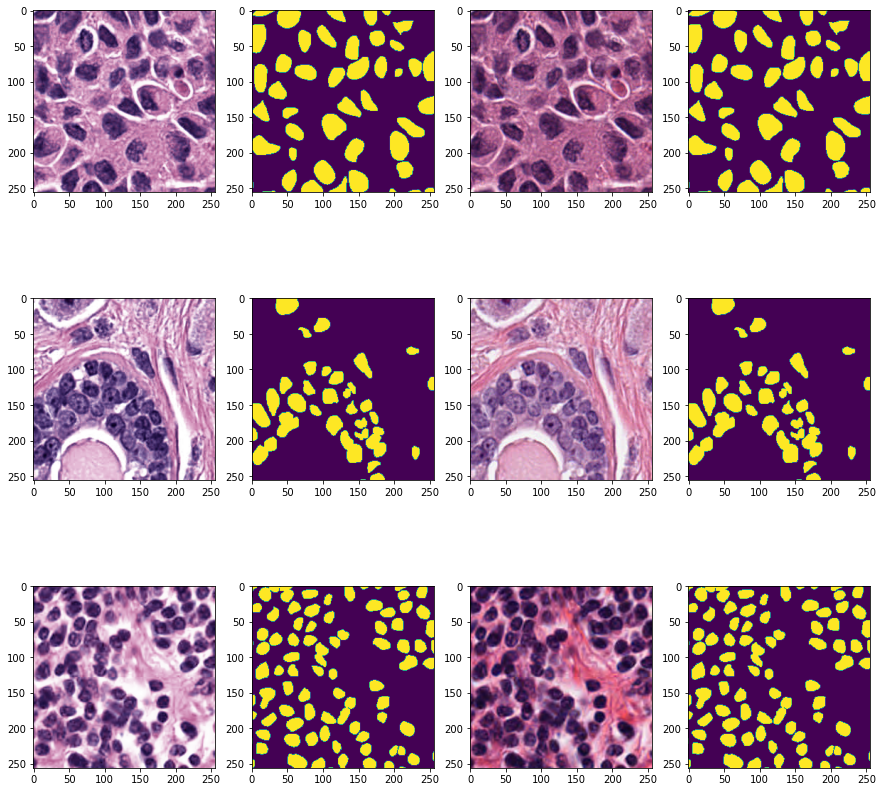

In [ ]:
n_images = 3
fig, axs = plt.subplots(n_images, 4, figsize = (15,15))
for i in range(n_images):
  j = random.randint(0, len(normalized_dataset['Training']['TissueImages'])-1)
  axs[i][0].imshow(array_to_img(normalized_dataset['Training']['TissueImages'][j]))
  axs[i][1].imshow(array_to_img(normalized_dataset['Training']['GroundTruth'][j]))
  axs[i][2].imshow(array_to_img(unnormalized_dataset['Training']['TissueImages'][j]))
  axs[i][3].imshow(array_to_img(unnormalized_dataset['Training']['GroundTruth'][j]))